In [756]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# Memuat dataset
data = pd.read_csv('dataset.csv')
data.head()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   kurun_waktu                 5 non-null      int64
 1   populasi_manusia            5 non-null      int64
 2   populasi_kendaraan_bensin   5 non-null      int64
 3   populasi_kendaraan_listrik  5 non-null      int64
 4   jumlah_karbon_kendaraan     5 non-null      int64
 5   aktivitas_manusia           5 non-null      int64
dtypes: int64(6)
memory usage: 372.0 bytes


In [757]:
# Tebakan awal untuk parameter
r = 0.015      # Laju pertumbuhan populasi per tahun
L = 3000e6     # Kapasitas maksimal populasi Indonesia
alpha = 0.00001 # Pengaruh CO2 terhadap pertumbuhan populasi
s = 0.15    # Laju pertumbuhan ekonomi per tahun
tau = 0.000015  # Pengaruh kendaraan bensin terhadap ekonomi
tau_e = 0.0001 # Pengaruh kendaraan listrik terhadap ekonomi
eta = 0.01    # Laju penurunan ekonomi
C0 = 5000     # Emisi CO2 dari sumber lain per tahun
gamma = 0.005  # Laju emisi CO2 per kendaraan bensin
sigma_e = 0.000025 # Laju emisi CO2 per kendaraan listrik
sigma = 0.0001  # Laju emisi CO2 dari aktivitas ekonomi
pi = 0.02     # Laju penurunan CO2 alami
beta = 0.00002 # Laju pertumbuhan kendaraan bensin
K_Vo = 25e6   # Kapasitas maksimal kendaraan bensin
xi_c = 0.0002  # Laju konversi dari kendaraan bensin ke listrik
r_Ve = 0.0270    # Laju pertumbuhan eksponensial kendaraan listrik


In [758]:
# Menyiapkan waktu (misalkan data tahunan dan dataset mencakup 10 tahun)
t = np.linspace(0, 10, len(data))  # Ganti dengan data['Year'] jika tahun tersedia

# Fungsi model dinamika
def model(y, t, params):
    N, H, C, Vo, Ve = y
    r, L, alpha, s, tau, tau_e, eta, C0, gamma, sigma_e, sigma, pi, beta, K_Vo, xi_c, r_Ve = params
    dNdt = r * N * (1 - N / L) - alpha * C
    dHdt = s * N + tau * Vo + tau_e * Ve - eta * H
    dCdt = C0 + gamma * Vo + sigma_e * Ve + sigma * H - pi * C
    dVodt = beta * N * (1 - Vo / K_Vo) - xi_c * Vo
    dVedt = r_Ve * Ve + xi_c * Vo
    return [dNdt, dHdt, dCdt, dVodt, dVedt]

# Kondisi awal (tebakan berdasarkan data pertama)
initial_conditions = [data['populasi_manusia'].iloc[0], data['aktivitas_manusia'].iloc[0],
                      data['jumlah_karbon_kendaraan'].iloc[0], data['populasi_kendaraan_bensin'].iloc[0],
                      data['populasi_kendaraan_listrik'].iloc[0]]


# bounds = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0, 0], 
#           [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
# Parameter
params = [r, L, alpha, s, tau, tau_e, eta, C0, gamma, sigma_e, sigma, pi, beta, K_Vo, xi_c, r_Ve]

# Generate simulated data
simulated = odeint(model, initial_conditions, t, args=(params,))

In [759]:
def fit_func(t, r, L, alpha, s, tau, tau_e, eta, C0, gamma, sigma_e, sigma, pi, beta, K_Vo, xi_c, r_Ve):
    params = [r, L, alpha, s, tau, tau_e, eta, C0, gamma, sigma_e, sigma, pi, beta, K_Vo, xi_c, r_Ve]
    result = odeint(model, initial_conditions, t, args=(params,))
    return result.flatten()

# Data target untuk fitting
target_data = np.column_stack((data['populasi_manusia'], data['aktivitas_manusia'],
                               data['jumlah_karbon_kendaraan'], data['populasi_kendaraan_bensin'],
                               data['populasi_kendaraan_listrik'])).flatten()

# Fitting the model
popt, pcov = curve_fit(fit_func, t, target_data, p0=params, maxfev=5000)

# Print optimized parameters
print("Optimized parameters:")
print(popt)

Optimized parameters:
[-3.42067474e-03 -2.70939193e+08 -2.17625873e-02  3.88287352e-01
 -9.79568062e-01  1.61844260e+02 -4.16772289e-01 -8.53309697e+03
  6.54355322e+00  5.98933748e+02 -1.44705804e+01  9.11884447e-01
  7.72538818e-03  1.07301104e+11  1.87560595e-04 -3.11962195e-01]


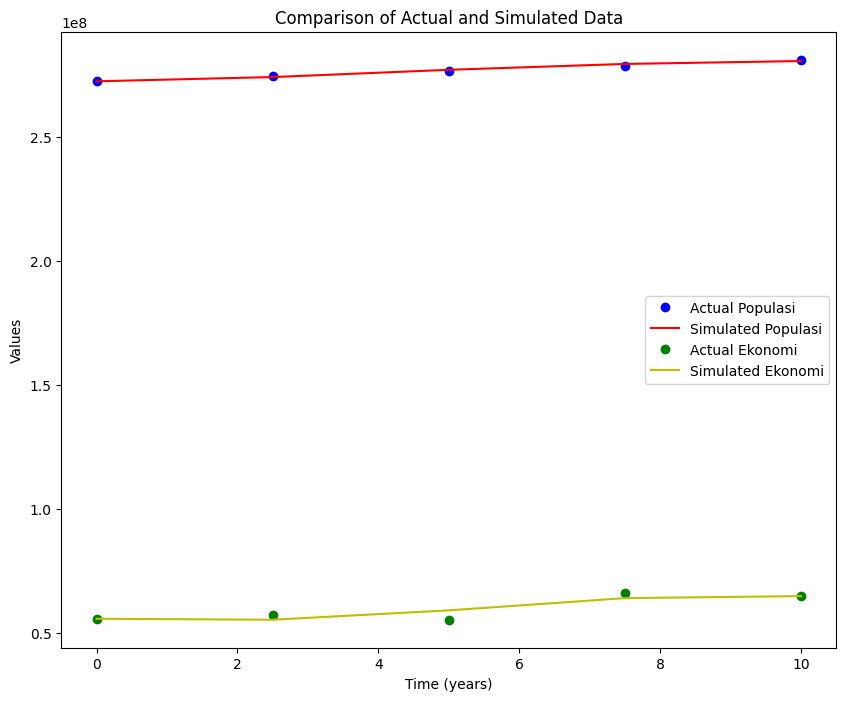

In [760]:
# Simulate with optimized parameters
simulated_opt = odeint(model, initial_conditions, t, args=(popt,))

# Plot comparison
plt.figure(figsize=(10, 8))
plt.plot(t, data['populasi_manusia'], 'bo', label='Actual Populasi')
plt.plot(t, simulated_opt[:, 0], 'r-', label='Simulated Populasi')
plt.plot(t, data['aktivitas_manusia'], 'go', label='Actual Ekonomi')
plt.plot(t, simulated_opt[:, 1], 'y-', label='Simulated Ekonomi')
plt.legend()
plt.title("Comparison of Actual and Simulated Data")
plt.xlabel("Time (years)")
plt.ylabel("Values")
plt.show()


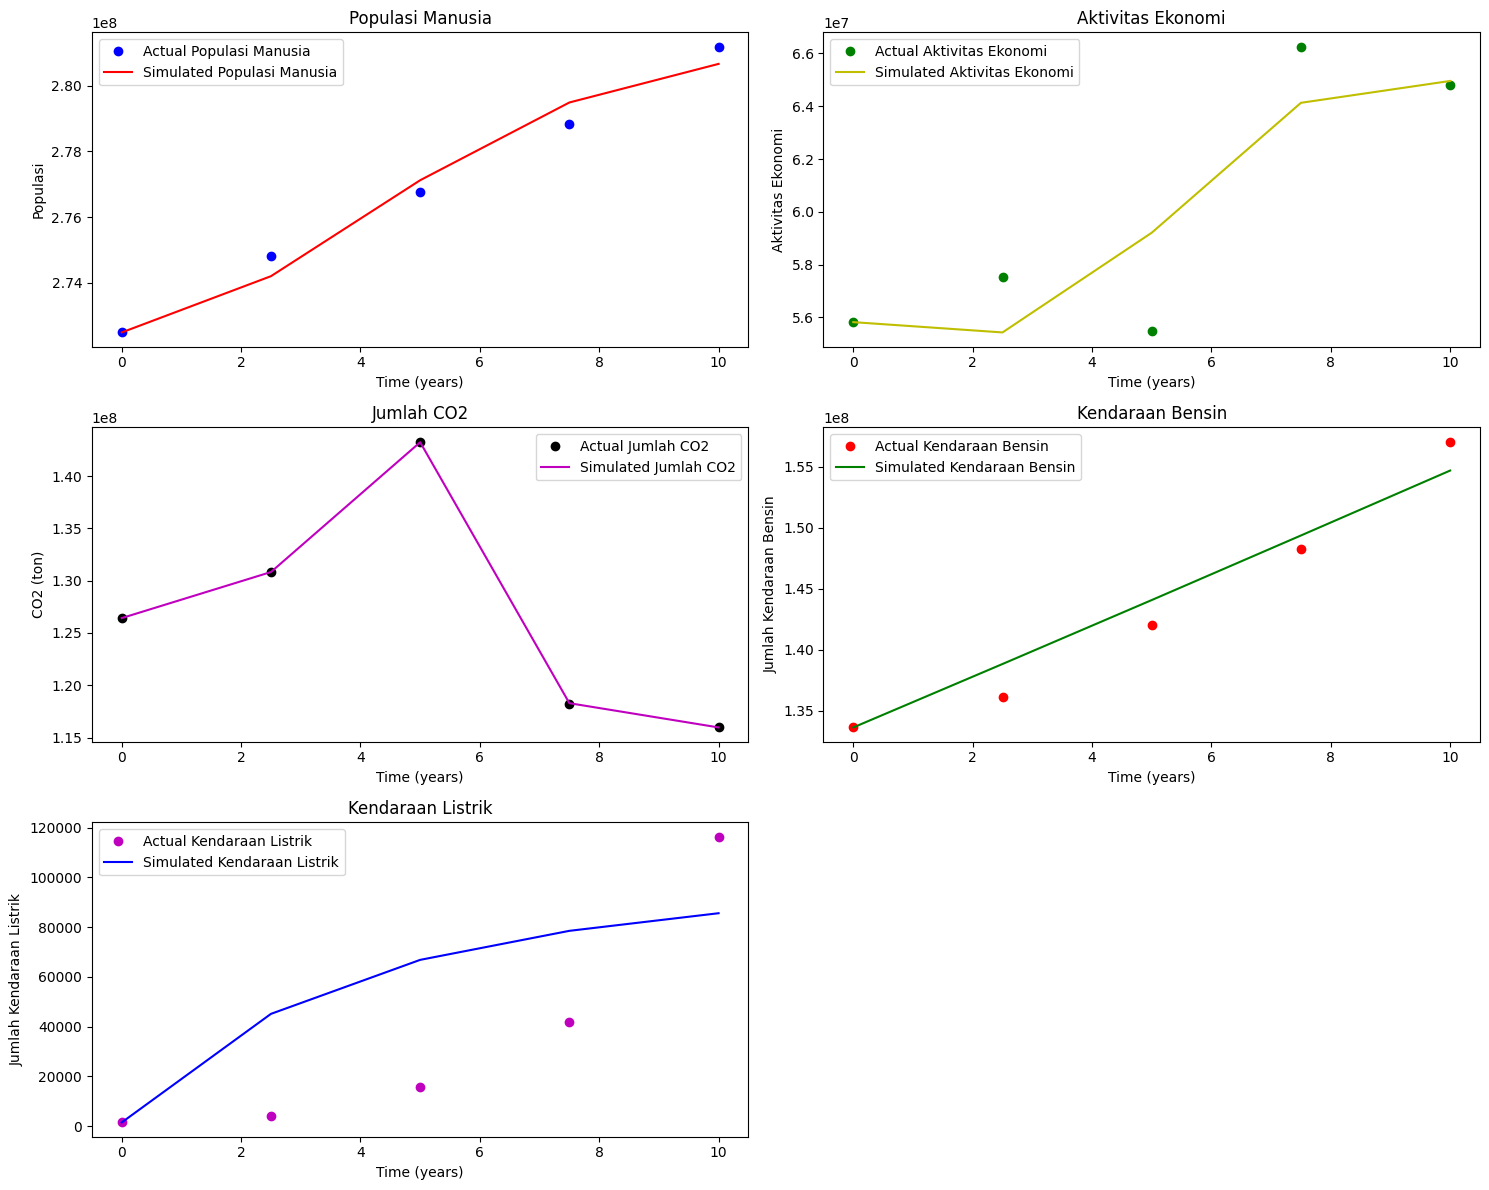

In [761]:
plt.figure(figsize=(15, 12))

# Plot untuk Populasi Manusia
plt.subplot(3, 2, 1)
plt.plot(t, data['populasi_manusia'], 'bo', label='Actual Populasi Manusia')
plt.plot(t, simulated_opt[:, 0], 'r-', label='Simulated Populasi Manusia')
plt.title("Populasi Manusia")
plt.xlabel("Time (years)")
plt.ylabel("Populasi")
plt.legend()

# Plot untuk Aktivitas Ekonomi
plt.subplot(3, 2, 2)
plt.plot(t, data['aktivitas_manusia'], 'go', label='Actual Aktivitas Ekonomi')
plt.plot(t, simulated_opt[:, 1], 'y-', label='Simulated Aktivitas Ekonomi')
plt.title("Aktivitas Ekonomi")
plt.xlabel("Time (years)")
plt.ylabel("Aktivitas Ekonomi")
plt.legend()

# Plot untuk Jumlah CO2
plt.subplot(3, 2, 3)
plt.plot(t, data['jumlah_karbon_kendaraan'], 'ko', label='Actual Jumlah CO2')
plt.plot(t, simulated_opt[:, 2], 'm-', label='Simulated Jumlah CO2')
plt.title("Jumlah CO2")
plt.xlabel("Time (years)")
plt.ylabel("CO2 (ton)")
plt.legend()

# Plot untuk Kendaraan Bensin
plt.subplot(3, 2, 4)
plt.plot(t, data['populasi_kendaraan_bensin'], 'ro', label='Actual Kendaraan Bensin')
plt.plot(t, simulated_opt[:, 3], 'g-', label='Simulated Kendaraan Bensin')
plt.title("Kendaraan Bensin")
plt.xlabel("Time (years)")
plt.ylabel("Jumlah Kendaraan Bensin")
plt.legend()

# Plot untuk Kendaraan Listrik
plt.subplot(3, 2, 5)
plt.plot(t, data['populasi_kendaraan_listrik'], 'mo', label='Actual Kendaraan Listrik')
plt.plot(t, simulated_opt[:, 4], 'b-', label='Simulated Kendaraan Listrik')
plt.title("Kendaraan Listrik")
plt.xlabel("Time (years)")
plt.ylabel("Jumlah Kendaraan Listrik")
plt.legend()

plt.tight_layout()
plt.show()

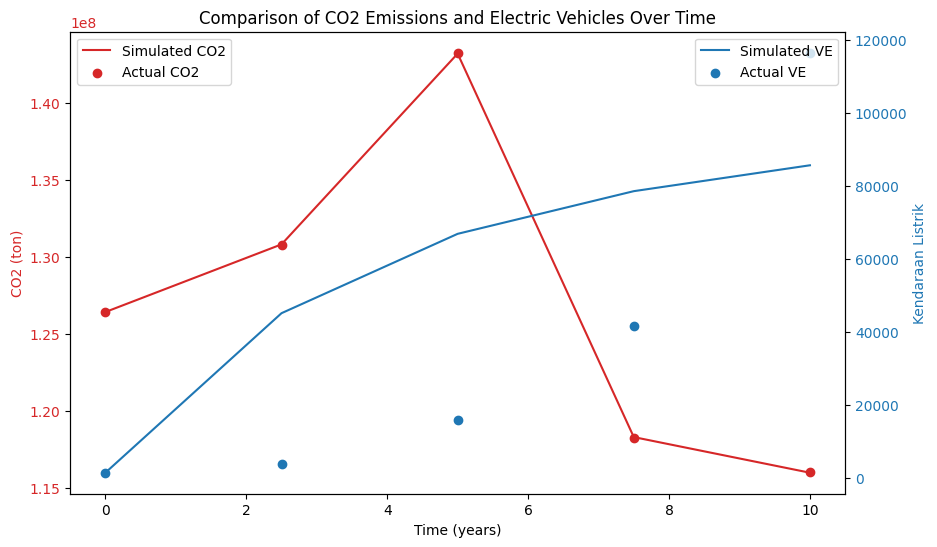

In [762]:
import matplotlib.pyplot as plt

# Membuat figure dan axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Warna untuk masing-masing axis
color = 'tab:red'
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('CO2 (ton)', color=color)
ax1.plot(t, simulated_opt[:, 2], color=color, label='Simulated CO2')  # asumsikan ini adalah index dari CO2
ax1.tick_params(axis='y', labelcolor=color)
ax1.scatter(t, data['jumlah_karbon_kendaraan'], color=color, marker='o', label='Actual CO2')  # Plot data aktual CO2
ax1.legend(loc='upper left')

# Membuat axis kedua
ax2 = ax1.twinx()  # Membuat sumbu Y baru yang berbagi sumbu X yang sama
color = 'tab:blue'
ax2.set_ylabel('Kendaraan Listrik', color=color)  # we already handled the x-label with ax1
ax2.plot(t, simulated_opt[:, 4], color=color, label='Simulated VE')  # asumsikan ini adalah index dari kendaraan listrik
ax2.tick_params(axis='y', labelcolor=color)
ax2.scatter(t, data['populasi_kendaraan_listrik'], color=color, marker='o', label='Actual VE')  # Plot data aktual kendaraan listrik
ax2.legend(loc='upper right')

# Tampilkan plot
plt.title('Comparison of CO2 Emissions and Electric Vehicles Over Time')
plt.show()
